# AUTOENCODER - Introducciónn

# AUTOENCODER

Los autoencoders son un tipo de redes neuronales en las que la entrada y la salida del modelo es la misma, es decir, redes entrenadas para predecir un resultado igual a los datos de entrada.    

Para conseguir este tipo de comportamiento, la arquitectura de los autoencoders es simétrica, con una región llamada encoder y otra decoder.    

## ¿Cómo sirve esto para reducir la dimensionalidad?    

Los autoencoders siguen una arquitectura de cuello de botella, la región encoder está formada por una o varias capas, cada una con menos neuronas que su capa precedente, obligando así a que la información de entrada se vaya comprimiendo.    

En la región decoder esta compresión se revierte siguiendo la misma estructura pero esta vez de menos a más neuronas.   

<img src="/workspaces/workspaceAI/CEIABD_MODULOS_IA/MODELOS DE INTELIGENCIA ARTIFICIAL/NOTEBOOKS DEL AULA/img/autoencoder2.png" width=400>   


Para conseguir que la salida reconstruida sea lo más parecida posible a la entrada, el modelo debe aprender a capturar toda la información posible en la zona intermedia. Una vez entrenado, la salida de la capa central del autoencoder (la capa con menos neuronas) es una representación de los datos de entrada pero con una dimensionalidad igual el número de neuronas de esta capa.

La principal ventaja de los autoencoders es que no tienen ninguna restricción en cuanto al tipo de relaciones que pueden aprender, por lo tanto, a diferencia de técnicas como la PCA, la reducción de dimensionalidad puede incluir relaciones no lineales.    

La desventaja es su alto riesgo de sobreentrenamiento (overfitting), por lo que se recomienda emplear muy pocas épocas y siempre evaluar la evolución del error con un conjunto de validación.

En el caso de utilizar funciones de activación lineales, las variables generadas en el cuello de botella (la capa con menos neuronas), son muy similares a las componentes principales de un PCA pero sin que necesariamente tengan que ser ortogonales entre ellas.

Este notebook contiene tres ejemplos de autoencoder:    
- conceptos básicos, 
- eliminación de ruido en imágenes y 
- detección de anomalías.

Para saber más sobre los autoencoders, es aconsejable leer el capítulo 14 de [Deep Learning](https://www.deeplearningbook.org/) de Ian Goodfellow, Yoshua Bengio y Aaron Courville.

## Librerías a importar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2025-03-20 12:26:20.280474: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 12:26:20.320564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742473580.369610   52259 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742473580.387208   52259 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 12:26:20.441388: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Carga del primer dataset   

Para empezar, se prepara un ejercicio para un autoencoder básico utilizando el dataset Fashion MNIST. Cada imagen de este dataset tiene 28x28 píxeles.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## Primer ejemplo: Autoencoder Básico  

Se define un autocodificador con dos capas densas: un `codificador`, que comprime las imágenes en un vector latente de 64 dimensiones (espacio latente), y un `decodificador`, que reconstruye la imagen original a partir del espacio latente.

In [3]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


2025-03-20 12:36:20.070770: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Compilación del AUTOENCODER

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Entrenamiento del modelo    

Se usa el conjunto `x_train` como entrada y como objetivo. El `encoder` aprenderá a comprimir el conjunto de datos de 784 dimensiones al espacio latente, y el `decoder` aprenderá a reconstruir las imágenes originales.

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0401 - val_loss: 0.0136
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0125 - val_loss: 0.0108
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0088 - val_loss: 0.0088


Ahora que el modelo está entrenado, se prueba codificando y descodificando imágenes del conjunto de prueba.

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

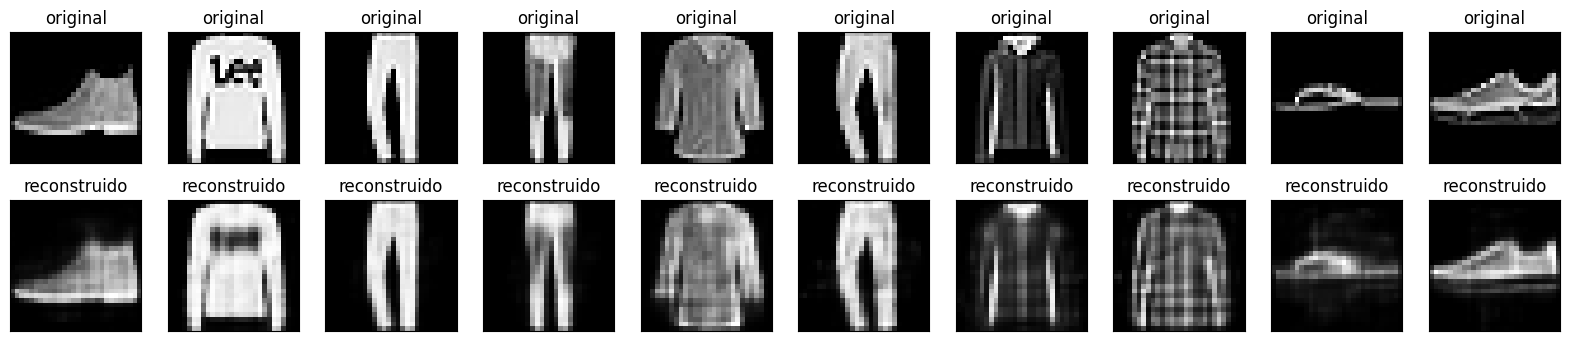

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstruido")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Segundo Ejemplo: Eliminación de ruido en imágenes


<img src="/workspaces/workspaceAI/CEIABD_MODULOS_IA/MODELOS DE INTELIGENCIA ARTIFICIAL/NOTEBOOKS DEL AULA/img/image_denoise_fmnist_results.png">

También se puede entrenar un autoencoder para eliminar el ruido de las imágenes.    
En la siguiente sección, se crea una versión "ruidosa" del dataset Fashion MNIST aplicando ruido aleatorio a cada imagen.    
A continuación, se entrena un autoencoder utilizando la imagen ruidosa como entrada y la imagen original como objetivo.

Se vuelve a importar el dataset para omitir las modificaciones realizadas previamente.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Añadiendo el ruido aleatorio a las imágenes.

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Graficado de las imágenes con el ruido añadido


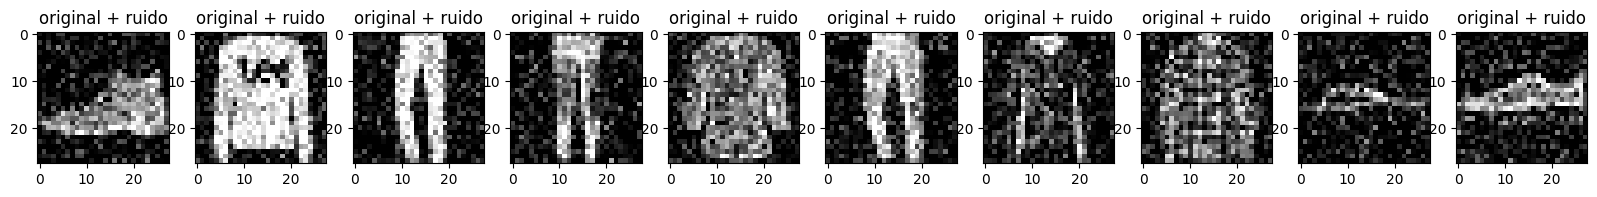

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + ruido")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Definición de un Autoencoder Convolucional

En este ejemplo, se usará un autoencoder convolucional usando capas [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) en el `encoder`, y capas [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) en el `decoder`.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

Compilación del Autoencoder Convolucional

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Entrenamiento del modelo

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - loss: 0.0362 - val_loss: 0.0099
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - loss: 0.0070 - val_loss: 0.0070


Si se muestra un resumen del codificador, se observa cómo las imágenes se reducen de 28x28 a 7x7.

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

El descodificador aumenta la resolución de las imágenes de 7x7 a 28x28.

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (32, 14, 14, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (32, 28, 28, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

Representación gráfica de las imágenes con ruido y de las imágenes "limpiadas" que genera el autoencoder.

In [18]:
# Se decodifican las imágenes ruidosas para compararlas con las originales
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

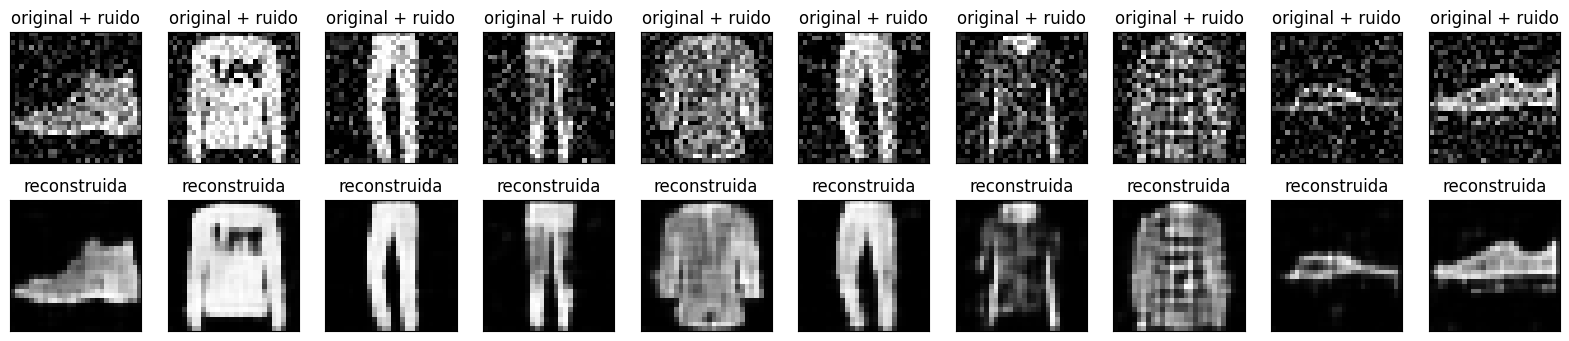

In [19]:
# Se grafican las imágenes originales, con ruido, y las reconstruidas
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + ruido
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + ruido")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstrución
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstruida")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Tercer Ejemplo: Detección de anomalías.

## Resumen


En este ejemplo, se entrena un autoencoder para detectar anomalías en el [dataset ECG5000](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Este dataset contiene 5.000 [Electrocardiogramas](https://en.wikipedia.org/wiki/Electrocardiography), cada uno con 140 puntos de datos.    
Se utilizará una versión simplificada del dataset, en la que cada ejemplo se ha etiquetado como «0» (correspondiente a un ritmo anormal) o «1» (correspondiente a un ritmo normal).    

Lo que se pretende es identificar los **ritmos anormales**.

Nota: se trata de un dataset etiquetados, por lo que podría plantearse como un problema de aprendizaje supervisado. El objetivo de este ejemplo es ilustrar los conceptos de detección de anomalías que se pueden aplicar a datasets más grandes, en los que no se dispone de etiquetas (por ejemplo, si se tienen muchos miles de ritmos normales y sólo un pequeño número de ritmos anormales).

**¿Cómo se detectan las anomalías con un autoencoder?**   

Recordemos que un autoencoder se entrena para minimizar el error de reconstrucción. Se va a entrenar un autoencoder sólo con los ritmos normales y luego se utilizará para reconstruir todos los datos.   

La hipótesis de partida es que los ritmos anormales tendrán un mayor error de reconstrucción.    

A continuación, se clasificará un ritmo como anómalo si el error de reconstrucción supera un determinado umbral fijado.

### Carga del dataset con la información de los ECG

El dataset que se utilizará se basa en uno de la web [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).

In [20]:
# Descarga del dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Preparación de la información del dataset descargado

In [21]:
# La última columna contiene las etiquetas
labels = raw_data[:, -1]


# El resto de los datos son los datos del electrocardiograma
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalización de los datos al intervalo `[0,1]`.

In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

Se entrena el autoencoder utilizando sólo los ritmos normales, que en este dataset se etiquetan como «1».    

A continuación, se separa los ritmos normales de los anormales.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Visualización de un ECG normal.

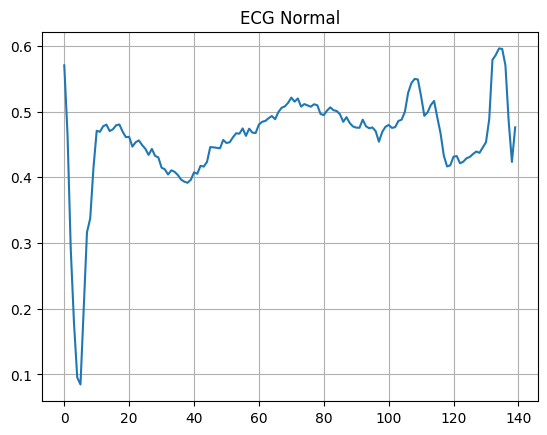

In [25]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("ECG Normal")
plt.show()

Visualizar un ECG anómalo.

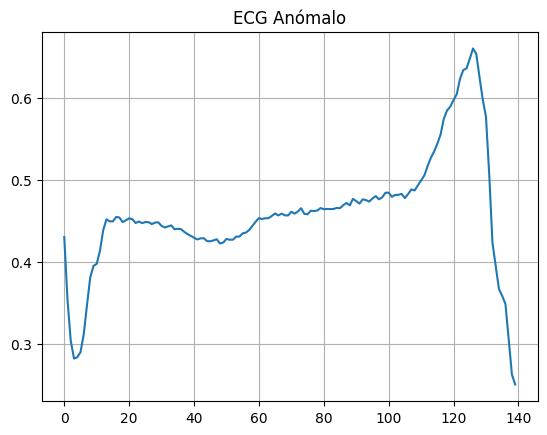

In [26]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("ECG Anómalo")
plt.show()

### Construcción del modelo de detección de anomalías

In [27]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

Compilación del modelo

In [28]:
autoencoder.compile(optimizer='adam', loss='mae')

Obsérvese que el autoencoder se entrena utilizando sólo los ECG normales, pero se evalúa utilizando el conjunto de pruebas completo.

In [29]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0581 - val_loss: 0.0533
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0560 - val_loss: 0.0519
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0532 - val_loss: 0.0504
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0498 - val_loss: 0.0484
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0460 - val_loss: 0.0462
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0425 - val_loss: 0.0442
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0388 - val_loss: 0.0422
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0356 - val_loss: 0.0406
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0326 - val_loss: 0.0389
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0303 - val_loss: 0.0379
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0283 - val_loss: 0.0371
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0268 - val_loss: 0.0362


Visualización de métricas de evaluación de nuestro modelo.

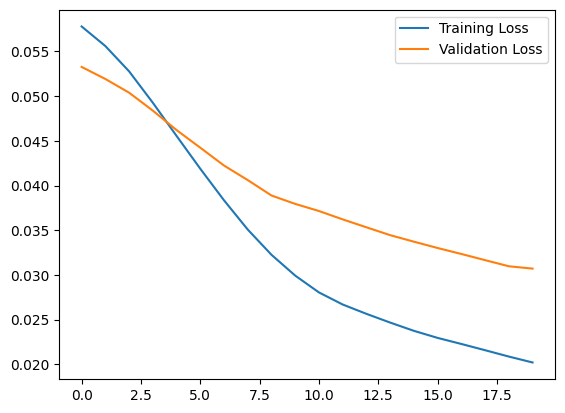

In [30]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Se clasificará un ECG como anómalo si el error de reconstrucción es superior a una desviación estándar, respecto a los ejemplos de entrenamiento normales.    

En primer lugar, se va a mostrar un ECG normal del conjunto de entrenamiento, la reconstrucción después de ser codificado y decodificado por el autoencoder, y el error de reconstrucción.

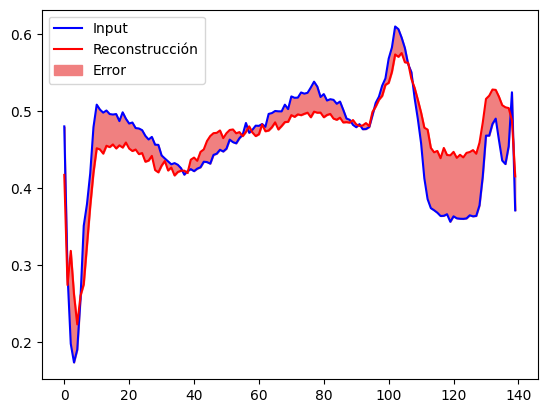

In [31]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstrucción", "Error"])
plt.show()

Ahora se crea un gráfico similar, esta vez para un ejemplo de prueba anómalo.

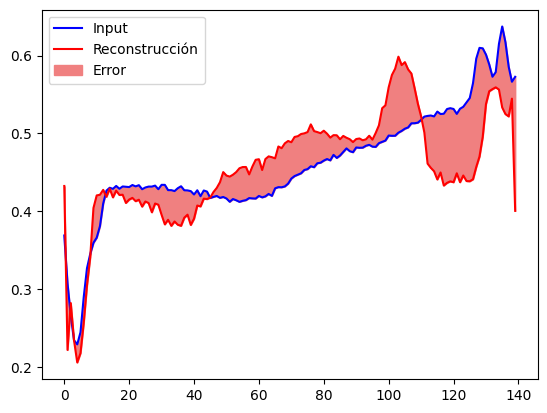

In [33]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstrucción", "Error"])
plt.show()

### Detectando anomalias

Se detectan las anomalías calculando si la pérdida de reconstrucción es mayor que un umbral determinado.    

En este caso, se calculará el error medio promedio de los ejemplos normales del conjunto de entrenamiento y, a continuación, se clasificarán los ejemplos futuros como anómalos si el error de reconstrucción es superior a una desviación estándar del conjunto de entrenamiento.

Gráfico del error de reconstrucción en ECG normales del conjunto de entrenamiento

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


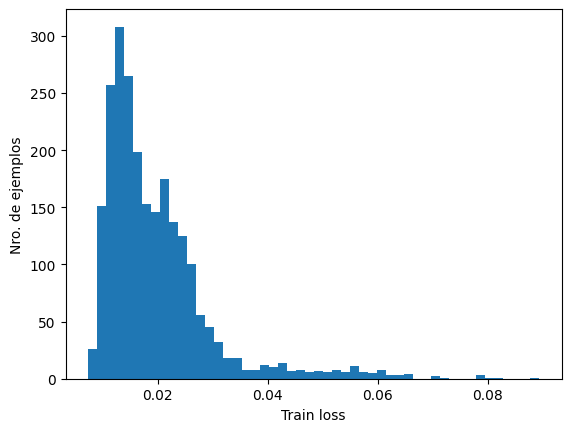

In [34]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("Nro. de ejemplos")
plt.show()

Se selecciona un valor umbral que esté una desviación estándar por encima de la media.

In [35]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Umbral: ", threshold)

Umbral:  0.02991473


Nota: Existen otras estrategias que podría utilizar para seleccionar un valor umbral por encima del cual los ejemplos de prueba deberían clasificarse como anómalos. El enfoque correcto dependerá de su conjunto de datos.

Si se analiza el error de reconstrucción de los ejemplos anómalos del conjunto de prueba, se observa que la mayoría tiene un error de reconstrucción mayor que el umbral. Variando el umbral, es posible ajustar la [precisión](https://developers.google.com/machine-learning/glossary#precision) y la [recall](https://developers.google.com/machine-learning/glossary#recall) del clasificador.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


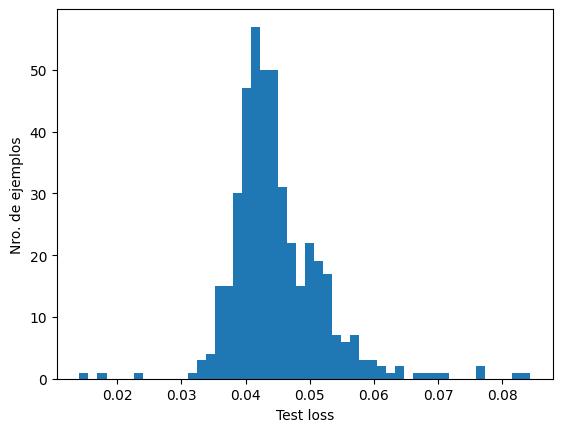

In [36]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("Nro. de ejemplos")
plt.show()

Finalmente, se preparan las funciones que van a evaluar el modelo, en el que se considera a un ECG como anomalía si el error de reconstrucción es superior al umbral establecido.

In [37]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [38]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.947
Precision = 0.9941520467836257
Recall = 0.9107142857142857


## Para saber más...

Para aprender más sobre la detección de anomalías con autoencoders, echa un vistazo a este excelente [ejemplo interactivo](https://anomagram.fastforwardlabs.com/#/) construido con TensorFlow.js por Victor Dibia. Para un caso de uso en el mundo real, puedes aprender cómo [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) usando TensorFlow. Para obtener más información sobre los conceptos básicos, considere la posibilidad de leer esta [entrada de blog](https://blog.keras.io/building-autoencoders-in-keras.html) de François Chollet. Para más detalles, consulta el capítulo 14 de [Deep Learning](https://www.deeplearningbook.org/) de Ian Goodfellow, Yoshua Bengio y Aaron Courville.
